# General Setting

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext
import time
import random
import pandas as pd

In [2]:
torch.manual_seed(123)

vocabulary_size=20000
learning_rate=0.005
batch_size=32
num_epoch=15


embedding_size=32
hidden_size=256
num_classes=2
num_layers=1


# Device

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
df=pd.read_csv(r'/kaggle/input/dataset/data.csv')
df.shape

In [ ]:
!pip install -U torchtext==0.6

In [4]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 86.2 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator,LabelField

In [6]:
### Defining the feature processing

Text = Field(
    tokenize='spacy', # default splits on whitespace
    tokenizer_language='en_core_web_sm',
    include_lengths=True # NEW
)

### Defining the label processing

Label = LabelField(dtype=torch.long)

# Processing the dataset

In [ ]:
fields=[('review',Text),('sentiment',Label)]
dataset=TabularDataset(path='/kaggle/input/dataset/data.csv',format='csv',
                       skip_header=True,fields=fields) # Read data file

# Split dataset train/val/test

In [ ]:
train_data,val_data,test_data=dataset.split(
    split_ratio=[0.7,0.2,0.1],
    random_state=random.seed(123)
)

print(f'Num train: {len(train_data)}')
print(f'Num val: {len(val_data)}')
print(f'Num test: {len(test_data)}')

In [ ]:
print(vars(train_data[0])) # Example object using vars to see the value

# Build Vocabulary (vocab object)

Build the vocabulary based on the top "vocabulary_size" words

In [ ]:
Text.build_vocab(train_data,max_size=vocabulary_size)
Label.build_vocab(train_data)

print(f'Vocabulary size: {len(Text.vocab)}')
print(f'Number of classes: {len(Label.vocab)}')

- 25,002 not 25,000 because of the **<unk>** and **<pad>** tokens
- PyTorch RNNs can deal with arbitrary lengths due to dynamic graphs, but padding is necessary for padding sequences to the same length in a given minibatch so we can store those in an array

**Look at most common words**

In [ ]:
print(Text.vocab.freqs.most_common(20))

**Tokens corresponding to the first 10 indices (0,1,...,9)**

In [ ]:
print(Text.vocab.itos[:10]) # itos = integer-to-string

**Converting a string to an integer**

In [ ]:
print(Text.vocab.stoi['the']) # stoi = string-to-integer

**Class label**

In [ ]:
print(Label.vocab.stoi)

**Class label count**

In [ ]:
print(Label.vocab.freqs)

# Define DataLoaders

In [ ]:
train_loader,valid_loader,test_loader=BucketIterator.splits(
    (train_data,val_data,test_data),
    batch_size=batch_size,
    sort_within_batch=False,
    sort_key=lambda x: len(x.review),
    device=device
)

In [ ]:
print("Train")
for batch in train_loader:
    text = batch.review[0]
    sentiment = batch.sentiment
    print(f"Text matrix size: {text.size()}")
    print(f"Target matrix size: {sentiment.size()}")
    break

print("Valid")
for batch in valid_loader:
    text = batch.review[0]
    sentiment = batch.sentiment
    print(f"Text matrix size: {text.size()}")
    print(f"Target matrix size: {sentiment.size()}")
    break

print("Test")
for batch in test_loader:
    text = batch.review[0]
    sentiment = batch.sentiment
    print(f"Text matrix size: {text.size()}")
    print(f"Target matrix size: {sentiment.size()}")
    break

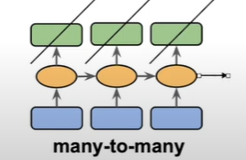

# Model

In [9]:
class RNN(nn.Module):
  def __init__(self,input_size,hidden_size,embedding_size,num_layers,num_classes):
    super(RNN,self).__init__()
    self.hidden_size=hidden_size
    self.num_layers=num_layers

    self.embedding=torch.nn.Embedding(input_size,embedding_size) # word to vector
    self.lstm=torch.nn.LSTM(input_size=embedding_size,hidden_size=hidden_size,num_layers=num_layers)
    self.fc=nn.Linear(hidden_size,num_classes)

  def forward(self,text):
    # text dim: [sentence length,batch size]
    embedded=self.embedding(text)
    # embedded dim: [sentence length, batch size, embedding dim]

    h0=torch.zeros(self.num_layers,text.shape[1],self.hidden_size).to(device)
    c0=torch.zeros(self.num_layers,text.shape[1],self.hidden_size).to(device)

    out,(hidden,cell)=self.lstm(embedded,(h0,c0))
    # output dim: [sentence length, batch size, hidden dim]
    # hidden dim: [num_layers,batch size, hidden dim]


    last_hidden = hidden[-1] # we gonna get output of hidden for the last hidden state (last step for the entire information)
    # last_hidden dim: [batch size, hidden dim]

    out=self.fc(last_hidden)

    return out


In [10]:
torch.manual_seed(123)
model=RNN(len(Text.vocab),
          hidden_size,
          embedding_size,
          num_layers,
          num_classes).to(device)

AttributeError: 'Field' object has no attribute 'vocab'

# Setup loss and optimize

In [ ]:
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(params=model1.parameters(),lr=learning_rate)

In [11]:
def check_accuracy(dataloader,model):
  num_correct=0
  num_samples=0
  total_loss=0


  model.eval()
  with torch.no_grad():
    for x in dataloader:
      data=x.review[0]
      y=x.sentiment
      feature=data.to(device=device)
      target=y.to(device=device)

      y_pred=model(feature)
      _,predictions=y_pred.max(1)
      num_correct+=(predictions==target).sum()
      num_samples+=predictions.shape[0]

      test_loss=loss_fn(y_pred,target)
      total_loss+=test_loss.item() # Get loss value
      avg_loss=total_loss / len(dataloader) # len(loader) represents the number of mini-batchs in the loader. Since you want to calculate the average loss per mini-batch, dividing the total loss by the number of mini-batches (len(loader)) gives you the correct average loss value.
      acc=float(num_correct)/float(num_samples) * 100

  return avg_loss,acc

# Train loop

In [ ]:
epoch_lst=[]
loss_val=[]
train_loss=[]
val_loss=[]
for epoch in range(num_epoch):
    for bat_idx, batch in enumerate(train_loader):
        features = batch.review[0]
        targets = batch.sentiment
        features = features.to(device=device)
        targets = targets.to(device=device)

        # Forward
        model.train()
        pred = model(features)
        loss = loss_fn(pred, targets)

        # Optimize
        optimizer.zero_grad()

        # Backward
        loss.backward()

        # Update
        optimizer.step()

    if epoch % 2 == 0:
        loss_test, acc_test = check_accuracy(test_loader, model)
        loss_train, acc_train = check_accuracy(train_loader, model)
        loss_vals, acc_val = check_accuracy(valid_loader, model)
        epoch_lst.append(epoch)
        loss_val.append(loss_test)
        train_loss.append(loss_train)
        val_loss.append(loss_vals)
        print(f"Epoch: {epoch} | Loss: {loss_test:.2f} | Acc: {acc_test:.2f} | Train loss: {loss_train:.2f} | Acc train: {acc_train:.2f} | Val loss: {loss_vals:.2f} | Acc val: {acc_val:.2f}")

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
lst=[train_loss,loss_val,val_loss]
label=['Train','Test','Validation']
for i in range(3):
    plt.figure(figsize=(12,6))
    plt.subplot(3,1,i+1)
    plt.plot(epoch_lst,lst[i],label=label[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(label[i])
    plt.legend()
    

In [ ]:
torch.save(model, '/kaggle/working/model.pt')

In [ ]:
model = torch.load('/kaggle/working/model.pt')
model.eval()

## Add data

In [7]:
new_df=pd.read_csv(r'/kaggle/input/moviedata/movie_data.csv')
new_df.shape

(50000, 2)

In [8]:
fields=[('review',Text),('sentiment',Label)]
dataset=TabularDataset(path='/kaggle/input/moviedata/movie_data.csv',format='csv',
                       skip_header=True,fields=fields) # Read data file

In [16]:
train_data1,val_data1,test_data1=dataset.split(
    split_ratio=[0.7,0.2,0.1],
    random_state=random.seed(123)
)

print(f'Num train: {len(train_data1)}')
print(f'Num val: {len(val_data1)}')
print(f'Num test: {len(test_data1)}')

Num train: 35000
Num val: 5000
Num test: 10000


In [17]:
Text.build_vocab(train_data1,max_size=20000)
Label.build_vocab(train_data1)

print(f'Vocabulary size: {len(Text.vocab)}')
print(f'Number of classes: {len(Label.vocab)}')

Vocabulary size: 20002
Number of classes: 2


In [18]:
train_loader1,valid_loader1,test_loader1=BucketIterator.splits(
    (train_data1,val_data1,test_data1),
    batch_size=batch_size,
    sort_within_batch=False,
    sort_key=lambda x: len(x.review),
    device=device
)

In [19]:
print("Train")
for batch in train_loader1:
    text = batch.review[0]
    sentiment = batch.sentiment
    print(f"Text matrix size: {text.size()}")
    print(f"Target matrix size: {sentiment.size()}")
    break

print("Valid")
for batch in valid_loader1:
    text = batch.review[0]
    sentiment = batch.sentiment
    print(f"Text matrix size: {text.size()}")
    print(f"Target matrix size: {sentiment.size()}")
    break

print("Test")
for batch in test_loader1:
    text = batch.review[0]
    sentiment = batch.sentiment
    print(f"Text matrix size: {text.size()}")
    print(f"Target matrix size: {sentiment.size()}")
    break

Train
Text matrix size: torch.Size([1153, 32])
Target matrix size: torch.Size([32])
Valid
Text matrix size: torch.Size([45, 32])
Target matrix size: torch.Size([32])
Test
Text matrix size: torch.Size([42, 32])
Target matrix size: torch.Size([32])


In [20]:
torch.manual_seed(123)
model1=RNN(len(Text.vocab),
          hidden_size,
          embedding_size,
          num_layers,
          num_classes).to(device)

In [ ]:
epoch_lst=[]
loss_val1=[]
train_loss1=[]
val_loss1=[]
for epoch in range(num_epoch):
    for bat_idx, batch in enumerate(train_loader1):
        features = batch.review[0]
        targets = batch.sentiment
        features = features.to(device=device)
        targets = targets.to(device=device)

        # Forward
        model1.train()
        pred = model1(features)
        loss = loss_fn(pred, targets)

        # Optimize
        optimizer.zero_grad()

        # Backward
        loss.backward()

        # Update
        optimizer.step()

    if epoch % 2 == 0:
        loss_test1, acc_test1 = check_accuracy(test_loader1, model1)
        loss_train1, acc_train1 = check_accuracy(train_loader1, model1)
        loss_vals1, acc_val1 = check_accuracy(valid_loader1, model1)
        epoch_lst.append(epoch)
        loss_val1.append(loss_test1)
        train_loss1.append(loss_train1)
        val_loss1.append(loss_vals1)
        print(f"Epoch: {epoch} | Loss: {loss_test1:.2f} | Acc: {acc_test1:.2f} | Train loss: {loss_train1:.2f} | Acc train: {acc_train1:.2f} | Val loss: {loss_vals1:.2f} | Acc val: {acc_val1:.2f}")

In [ ]:
lst=[train_loss1,loss_val1,val_loss1]
label=['Train','Test','Validation']
for i in range(3):
    plt.figure(figsize=(12,6))
    plt.subplot(3,1,i+1)
    plt.plot(epoch_lst,lst[i],label=label[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(label[i])
    plt.legend()
    

In [ ]:
torch.save(model1, '/kaggle/working/model.pt')

# Prediction


In [21]:
model1=torch.load('/kaggle/input/model1/model (1).pt',map_location='cpu')

In [12]:
import spacy

In [46]:
nlp=spacy.load('en_core_web_sm')

def predict_sentiment(model,sentence):
    model1.eval()
    tokenized=[tok.text for tok in nlp.tokenizer(sentence)]
    indexed= [Text.vocab.stoi[t] for t in tokenized] #get index of words
    length=[len(indexed)]
    tensor=torch.LongTensor(indexed).to(device)
    tensor=tensor.unsqueeze(1)
    length_tensor=torch.LongTensor(length)
    prediction=F.softmax(model(tensor),dim=1)
#     return prediction[0][0].item() #predict probabillity, item() is get value of tensor
    return prediction[0][0].item()
# print(predict_sentiment(model1,'Such an terrible day'))

    
sentiment_score = predict_sentiment(model1, str(input('Input sentence: ')))
print('Sentiment score:', sentiment_score)

if sentiment_score > 0.5:
    print('Positive movie')
else:
    print('Negative movie')

Input sentence:  this movie made me crying in front of people, so bad, and the story of it is not good


Sentiment score: 0.013584916479885578
Negative movie


# Test model

In [35]:
new_df.tail()

,review,sentiment
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0
49999,I waited long to watch this movie. Also becaus...,1


In [40]:
new_df.iloc[49996,0]

"The British 'heritage film' industry is out of control. There's nothing wrong with filming classic novels, but why must they all be filmed by talentless nobodies? This film rips the guts out of Orwell's tough novel, turning it into a harmless, fluffy romantic comedy. 'Aspidistra' may not be Orwell's best work, but no-one who reads it can forget its superb depiction of poverty. Orwell emphasises not only the cold and the hunger, but the humiliation of being poor. In the novel, London is a bleak, grey, cold, heartless city, and Comstock prays for it to be blasted away by a squadron of bombers. But this film irons out anything that might be in any way disturbing, and creates instead a jolly nostalgic trip to charming 1930s London, in which everything is lit with shafts of golden sunlight, and even the slums of Lambeth are picturesque and filled with freshly scrubbed urchins and happy prostitutes. Comstock's poems about the sharp wind sweeping across the rubbish-strewn streets seem comple